# Predictive Modelling for pre-prepared runninng data.

Using project 3 team pre-prepared running data (Pace Curve over time)
This model predicts the duration (time) of a run based on the inputs of Distance, Elevation gain and Pace curve columns. These inputs are yet to be modelled and should offer some context to the performance of existing models.

This Notebook contains three models:
- Standard Linear Regression
- Ridge Regression
- Random Forest






In [2]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore') # ignore pop-ups

# Load the dataset
file_path = 'extended_activities_TRI001.csv'  # Take project 3 running dataset with max pace columns attached
data = pd.read_csv(file_path)

# Filter for runs only
running_data = data[data['Activity Type'] == 'Run']


ModuleNotFoundError: No module named 'pandas'

### Extensive eda for this dataset exists and for the purposes of this notebook we lean on the knowledge of previous analysis and move straight to feature selection and modelling.

In [ ]:
# Feature set for further modelling
features = [
    'Distance', 'Elevation Gain',
    'Maximum Pace 5s', 'Maximum Pace 10s', 'Maximum Pace 30s', 
    'Maximum Pace 1.0min', 'Maximum Pace 5.0min', 'Maximum Pace 10.0min', 
    'Maximum Pace 20.0min', 'Maximum Pace 30.0min', 
    'Maximum Pace 1.0 hr', 'Maximum Pace 1.5 hr', 'Maximum Pace 2.0 hr'
]

# Target variable and features
X = running_data[features]
y = running_data['Elapsed Time']

### Modelling key facts
- Train/test split of 80:20
- Use simple imputation to replace missing values with the median of the column
- Testing models of Linear Regression, Ridge Regression and Random Forest
- Use cross validation to determine the alpha value for Ridge model
- Use grid search to define the best parameters for random forest model
- Use the lesser of Root mean squared error (RMSE) as the success criteria


In [ ]:

# Split data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Add imputer object to replace missing values with the median of the column
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the Linear Regression model on training data
lr_model.fit(X_train_imputed, y_train)

# Predict on test set using Linear Regression
y_pred_lr = lr_model.predict(X_test_imputed)

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Define a range of alpha values for Ridge Regression
alphas = np.logspace(-6, 6, 13)

# Set Ridge Regression model with built in cross-val
ridge_cv_model = RidgeCV(alphas=alphas, store_cv_values=True)

# Train the Ridge Regression model on the training data
ridge_cv_model.fit(X_train_imputed, y_train)

# Predict on the test set using Ridge Regression
y_pred_ridge_cv = ridge_cv_model.predict(X_test_imputed)

# Calculate the MSE and Root Mean Squared Error RMSE for Ridge Regression
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = np.sqrt(mse_ridge_cv)

# Initialize the Random Forest Regressor

# Introduce the parameter grid to properly tune the model
rf_param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=12)
# Initialise a grid search to tune
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Train the Random Forest model on the imputed training data
rf_grid_search.fit(X_train_imputed, y_train)

# Retrieve the best model params
best_rf_model = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_

# Predict on the imputed test set using Random Forest
y_pred_rf = best_rf_model.predict(X_test_imputed)

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

#print("Linear Regression MSE: ", mse_lr)
print("Linear Regression RMSE: ", rmse_lr)
print("Ridge Regression Optimal Alpha: ", ridge_cv_model.alpha_)
#print("Ridge Regression MSE: ", mse_ridge_cv)
print("Ridge Regression RMSE: ", rmse_ridge_cv)
print(f"Best Random Forest Parameters: {best_params}")
#print("Random Forest MSE: ", mse_rf)
print("Random Forest RMSE: ", rmse_rf)


Linear Regression MSE:  821924.5941392167
Linear Regression RMSE:  906.6005703391195
Ridge Regression Optimal Alpha:  100.0
Ridge Regression MSE:  85534.75362142167
Ridge Regression RMSE:  292.46325174527766
Best Random Forest Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest MSE:  83583.95271756363
Random Forest RMSE:  289.10889422078253


Linear regression performs poorly, while Ridge regression requires a high alpha indicating it needs a relitivley relatively strong regularisation.
Random forest performs the strongest but compared to other company models, we can see that the variables are perhaps less optimal the RMSE for all models achieved a less accurate score given very similar models with 'Elevation gain' and some pace curve columns not present in other company models.

For these three features Random forest is recommended to predict running duration with these particular columns as features, from the testing.
While being the best predictor it's margain for error was still high compared to other predictive models for running data with approx. rmse = 289 or 4 minutes and 50 seconds off.

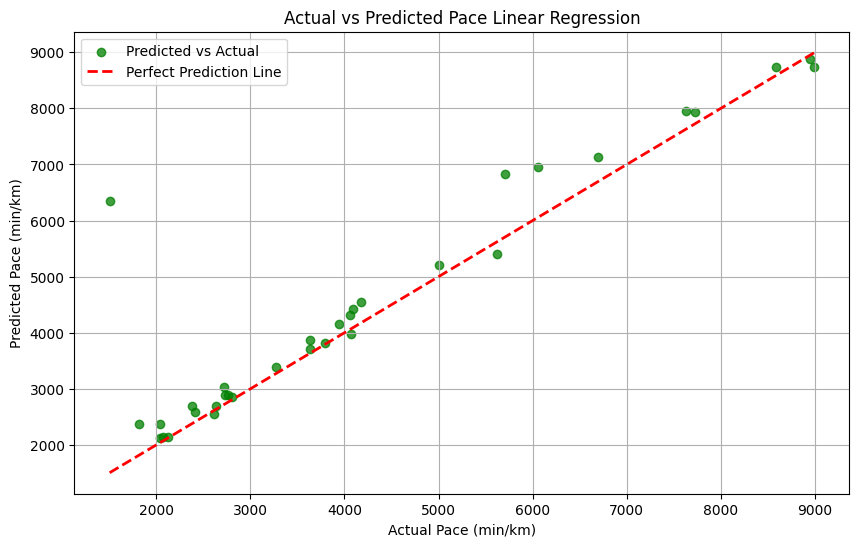

In [ ]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.75, color='green', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.title('Actual vs Predicted Pace Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

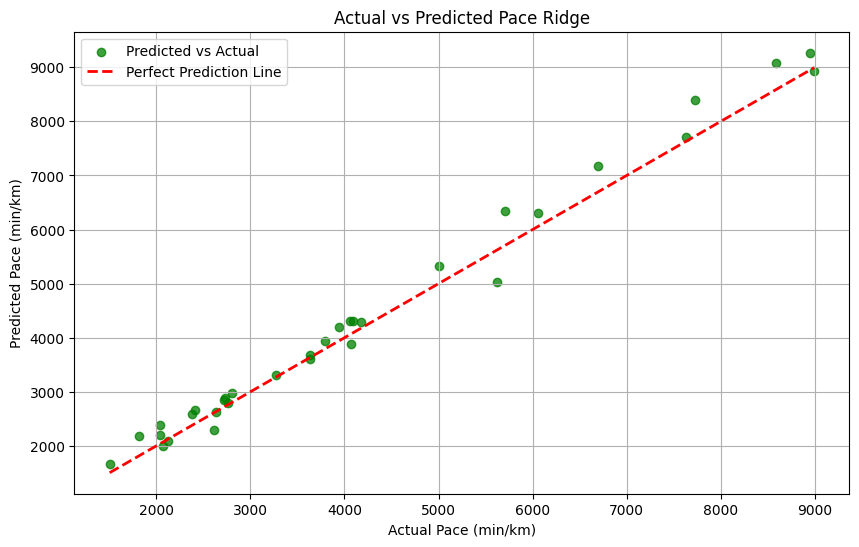

In [ ]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge_cv, alpha=0.75, color='green', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.title('Actual vs Predicted Pace Ridge')
plt.legend()
plt.grid(True)
plt.show()

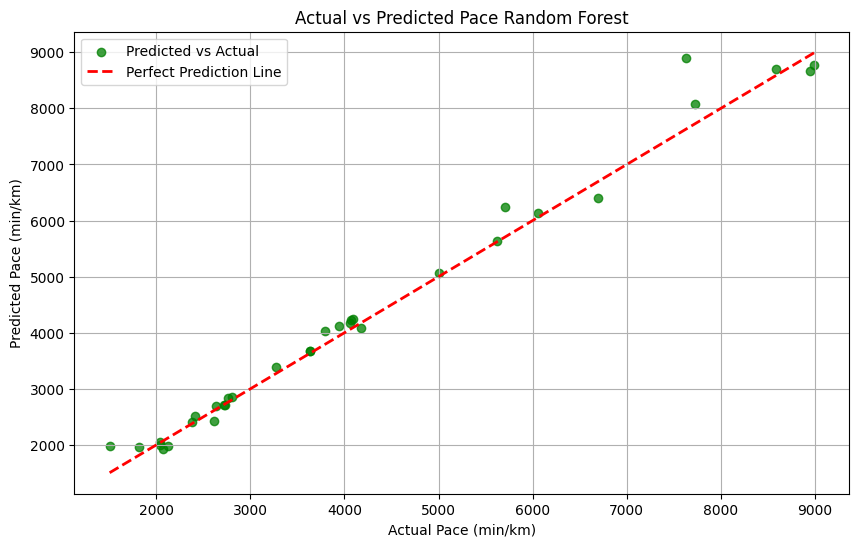

In [ ]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.75, color='green', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.title('Actual vs Predicted Pace Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### Visualisation
- We note that the visualisations are similar for all 3 models and to the eye, most values land close to the predicted line.
- Visually we can see an improvement from linear regression to ridge regression, adjusting for one particular outlier over the 2000 actual pace mark
- Moving from ridge to random forest, the overall cluster shrinks closer to the line for the medium values.